## Distribution of editing efficiency

### PRIDICT

The dataset of pridict-1 has 90k examples, the example suggests using a zero inflated poisson or gaussian distribution

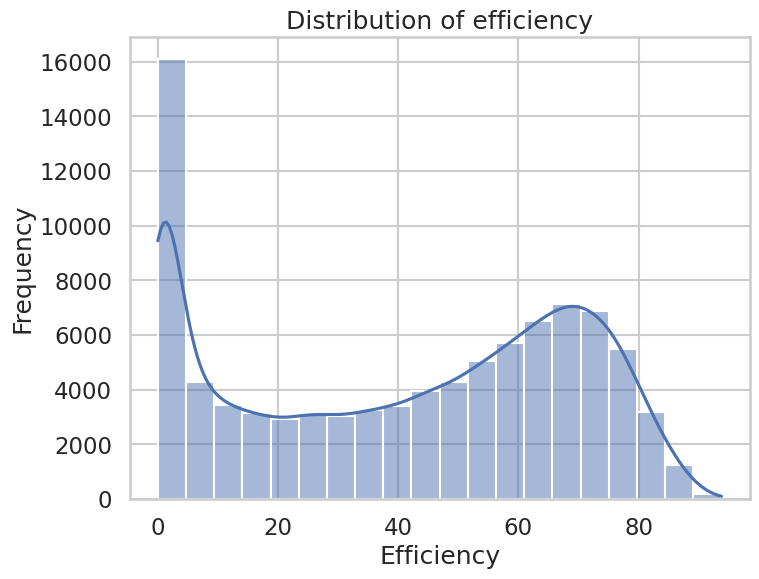

In [10]:
from os.path import join as pjoin

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
path = pjoin('data', 'pridict-90k.csv')
df = pd.read_csv(path)

efficiency_col = 'averageedited'
df = df[df[efficiency_col].notnull()]

# Plot the data
fig, ax = plt.subplots(figsize=(8, 6))
sns.set_context('talk')
sns.histplot(df[efficiency_col], bins=20, kde=True, ax=ax)
plt.xlabel('Efficiency')
plt.ylabel('Frequency')
plt.title('Distribution of efficiency')
plt.show()

# save the figure
fig.savefig(pjoin('figures', 'efficiency_distribution.png'))